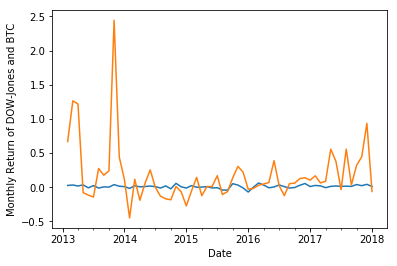

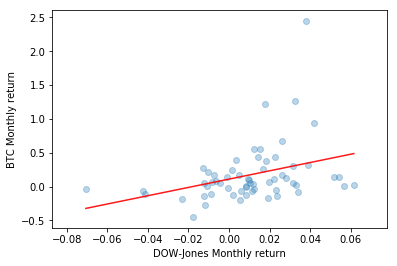

alpha = 0.1101707022297786

rvalue = 0.3409533207120896

slope = 6.134376395231807

std_err = 2.2208867689180427



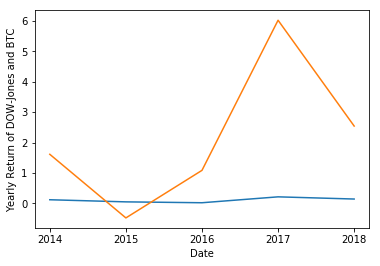

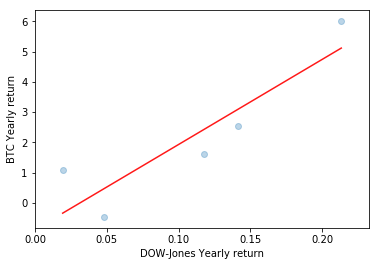

alpha = -0.8804548688496256

rvalue = 0.8936474091453406

slope = 28.117577126195314

std_err = 8.152196948610083



In [15]:
import numpy as np
import pandas as pd
import datetime
import scipy
import matplotlib.pyplot as pl
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import statsmodels.api as sm
from pandas_datareader.data import DataReader
from statsmodels import regression


def linear_regression(x,y):
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    x = x[:, 1]
    return model.params[0], model.params[1]



#Monthly

BTC = DataReader('BTC-USD',  'yahoo', '2013-01-01', '2018-01-01')
DOW = DataReader('^DJI',  'yahoo', '2013-01-01', '2018-01-01')

BTC_return_monthly = BTC.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
BTC_return_monthly = BTC_return_monthly.pct_change()[1:]
DOW_return_monthly = DOW.groupby(pd.Grouper(freq='MS'))['Adj Close'].mean()
DOW_return_monthly = DOW_return_monthly.pct_change()[1:]

DOW_return_monthly.plot()
BTC_return_monthly.plot()
pl.ylabel("Monthly Return of DOW-Jones and BTC")
pl.show()



X = DOW_return_monthly.values
Y = BTC_return_monthly.values

alpha, beta = linear_regression(X,Y)
X2 = np.linspace(X.min(), X.max(), 100)
Y_tilda = X2* beta + alpha
pl.scatter(X,Y, alpha = 0.3)
pl.xlabel("Dow-Jones Monthly return")
pl.ylabel("BTC Monthly return")
pl.plot(X2, Y_tilda, 'r', alpha = 0.9)
pl.show()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)

print("alpha = " + str(alpha) + "\n")
print("rvalue = " +  str(r_value) + "\n")
print("slope = " +   str(slope) + "\n")
print("std_err = " +  str(std_err) + "\n")




#Yearly

BTC_return_yearly = BTC.groupby(pd.Grouper(freq='YS'))['Adj Close'].mean()
BTC_return_yearly = BTC_return_yearly.pct_change()[1:]
DOW_return_yearly = DOW.groupby(pd.Grouper(freq='YS'))['Adj Close'].mean()
DOW_return_yearly = DOW_return_yearly.pct_change()[1:]

DOW_return_yearly.plot()
BTC_return_yearly.plot()
pl.ylabel("Yearly Return of DOW-Jones and BTC")
pl.show()



X = DOW_return_yearly.values
Y = BTC_return_yearly.values

alpha, beta = linear_regression(X,Y)
X2 = np.linspace(X.min(), X.max(), 100)
Y_tilda = X2* beta + alpha
pl.scatter(X,Y, alpha = 0.3)
pl.xlabel("Dow-Jones Yearly return")
pl.ylabel("BTC Yearly return")
pl.plot(X2, Y_tilda, 'r', alpha = 0.9)
pl.show()

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)
print("alpha = " + str(alpha) + "\n")
print("rvalue = " +  str(r_value) + "\n")
print("slope = " +   str(slope) + "\n")
print("std_err = " +  str(std_err) + "\n")




